<a href="https://colab.research.google.com/github/Ritheymg/Sentiment-Analysis-of-Customer-Reviews/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install & Import Libraries
!pip install transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline
import re
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing resource
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Load Data
df = pd.read_csv("/content/amazon_review.csv")
df.drop_duplicates(inplace=True)
df.dropna(subset=['reviewText', 'overall'], inplace=True)  # Ensure these important fields are present
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['day_diff'] = (pd.to_datetime('today') - df['reviewTime']).dt.days

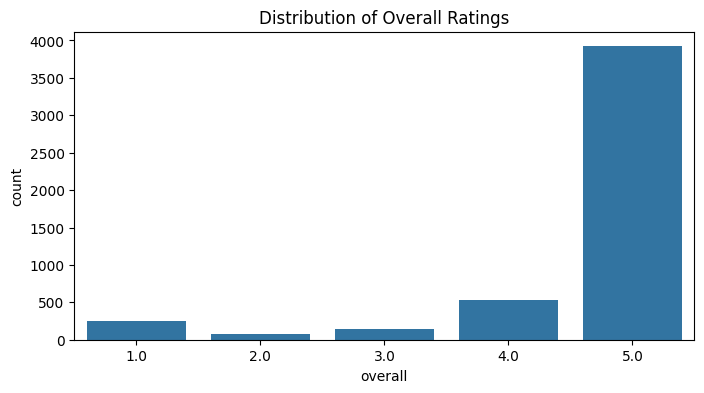

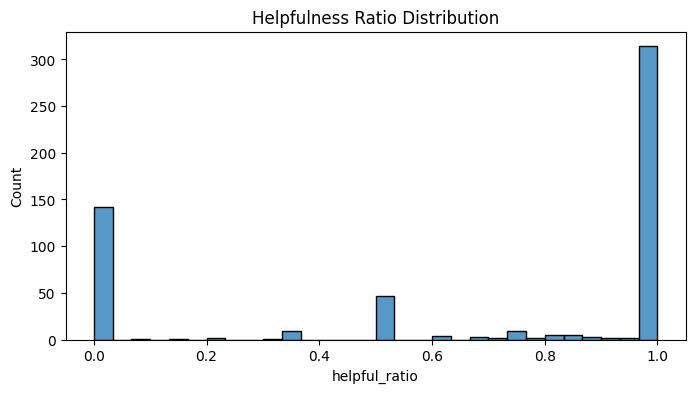

Time Weighted Avg Rating: 4.595493878979598


In [ ]:

# Basic Statistical Insight & Visualization
plt.figure(figsize=(8,4))
sns.countplot(x='overall', data=df)
plt.title('Distribution of Overall Ratings')
plt.show()

# Helpfulness Analysis
df['helpful_no'] = df['total_vote'] - df['helpful_yes']
df['helpful_ratio'] = df['helpful_yes'] / df['total_vote'].replace(0, np.nan)
plt.figure(figsize=(8,4))
sns.histplot(df['helpful_ratio'].dropna(), bins=30)
plt.title('Helpfulness Ratio Distribution')
plt.show()

# Time weighted average function for completeness
def time_based_weighted_average(dataframe, w1=28, w2=26, w3=24, w4=22):
    q1, q2, q3 = dataframe['day_diff'].quantile([0.25, 0.5, 0.75])
    return dataframe.loc[dataframe['day_diff']<=q1, 'overall'].mean()*w1/100 + \
           dataframe.loc[(dataframe['day_diff']>q1) & (dataframe['day_diff']<=q2), 'overall'].mean()*w2/100 + \
           dataframe.loc[(dataframe['day_diff']>q2) & (dataframe['day_diff']<=q3), 'overall'].mean()*w3/100 + \
           dataframe.loc[dataframe['day_diff']>q3, 'overall'].mean()*w4/100

print("Time Weighted Avg Rating:", time_based_weighted_average(df))

In [ ]:
# Sentiment Analysis Setup + Clean Review Text
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

nltk.download('punkt_tab') # Download the missing resource here

def clean_text(text):
    tokens = word_tokenize(str(text))
    filtered = [w for w in tokens if w.lower() not in stop_words and re.match(r'^\w+$', w)]
    return " ".join(filtered)

df['clean_reviewText'] = df['reviewText'].apply(clean_text)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


100%|██████████| 4914/4914 [06:42<00:00, 12.20it/s]


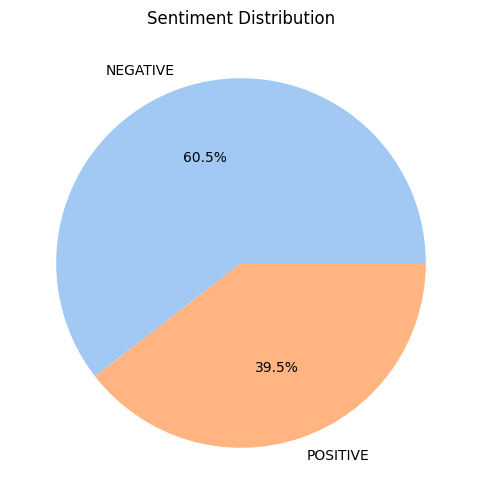

In [ ]:
# Label Sentiment on reviews
max_seq_length = 512
from tqdm import tqdm
tqdm.pandas()
df['sentiment'] = df['clean_reviewText'].progress_apply(lambda x: sentiment_analyzer(x[:max_seq_length])[0]['label'] if x.strip() else 'NEUTRAL')

# Sentiment Distribution Visualization
plt.figure(figsize=(6,6))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Sentiment Distribution")
plt.ylabel("")
plt.show()

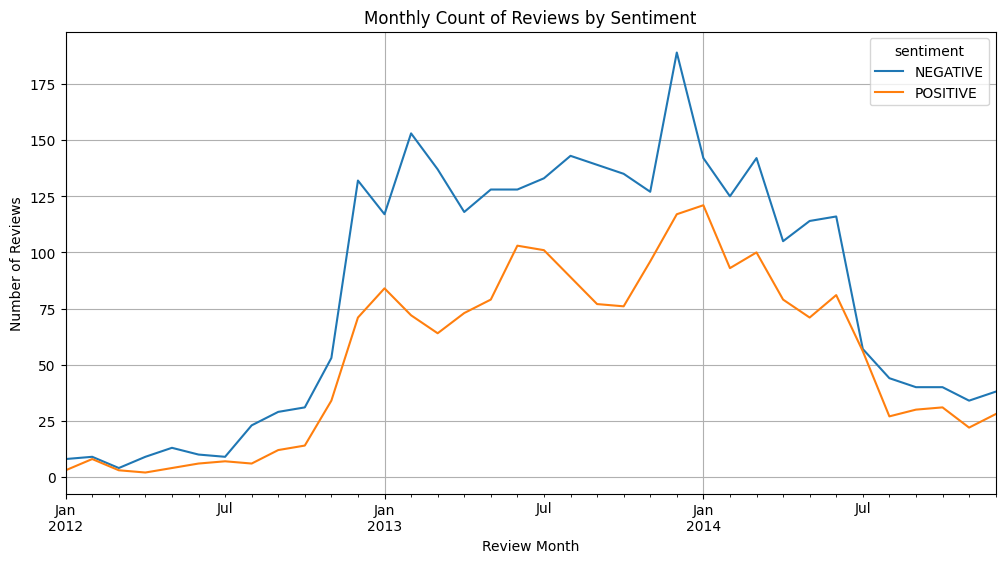

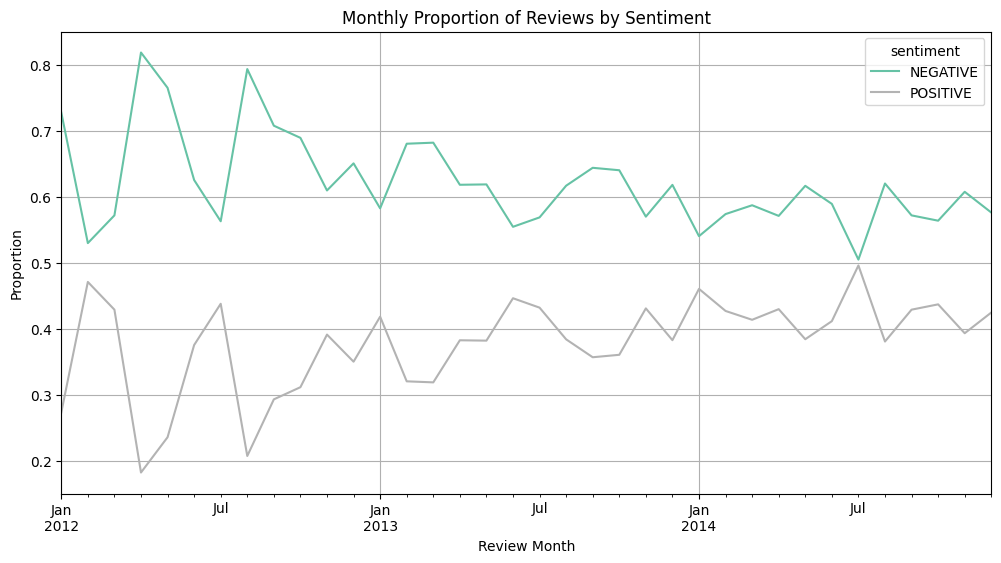

In [ ]:
#Trend Analysis by Month and Sentiment

#Convert to period for grouping
df['review_month'] = df['reviewTime'].dt.to_period('M')

# Count reviews by month and sentiment
monthly_sentiment = df.groupby(['review_month', 'sentiment']).size().unstack(fill_value=0)

# Normalize to get proportions over time
monthly_prop = monthly_sentiment.divide(monthly_sentiment.sum(axis=1), axis=0)

# Plot counts
monthly_sentiment.plot(kind='line', figsize=(12,6))
plt.title("Monthly Count of Reviews by Sentiment")
plt.ylabel("Number of Reviews")
plt.xlabel("Review Month")
plt.grid(True)
plt.show()

# Plot proportions
monthly_prop.plot(kind='line', figsize=(12,6), cmap='Set2')
plt.title("Monthly Proportion of Reviews by Sentiment")
plt.ylabel("Proportion")
plt.xlabel("Review Month")
plt.grid(True)
plt.show()


In [ ]:
from tqdm import tqdm
tqdm.pandas()

# Extract Negative Reviews for Issue Analysis
negative_reviews = df[df['sentiment'] == 'NEGATIVE']

# Zero-shot classification for pain points
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
categories = ['speed', 'capacity', 'reliability', 'price', 'performance', 'quality', 'compatibility']

def classify_issue(text):
    if text.strip():
        result = classifier(text, categories)
        return result['labels'][0]
    else:
        return 'unknown'

# Classify negative review summary or split sentences
negative_reviews['issue_category'] = negative_reviews['reviewText'].progress_apply(classify_issue)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu
100%|██████████| 2974/2974 [8:00:41<00:00,  9.70s/it]
/tmp/ipython-input-883369395.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['issue_category'] = negative_reviews['reviewText'].progress_apply(classify_issue)


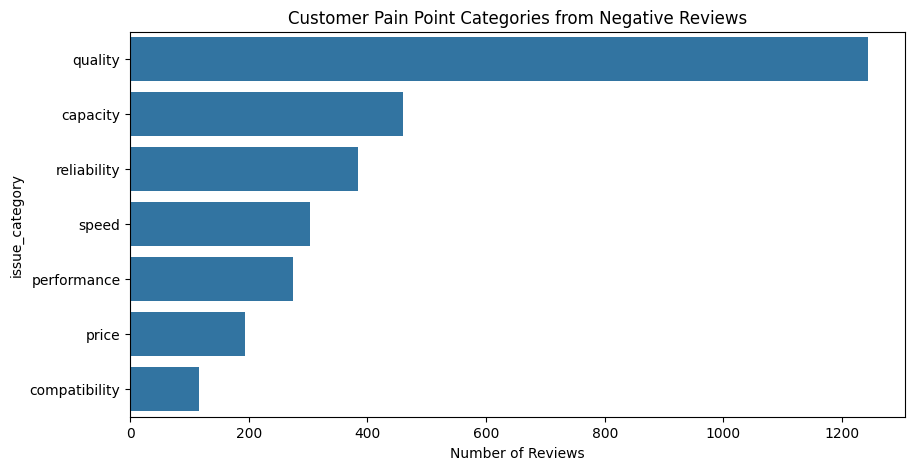

In [ ]:
# Pivot and visualize issue categories
plt.figure(figsize=(10,5))
sns.countplot(y='issue_category', data=negative_reviews, order=negative_reviews['issue_category'].value_counts().index)
plt.title('Customer Pain Point Categories from Negative Reviews')
plt.xlabel('Number of Reviews')
plt.show()

In [ ]:
#Topic Modelling using BERTopic
!pip install bertopic
from bertopic import BERTopic

# Clean texts for topic modeling (optional)
texts = df['clean_reviewText'].astype(str).tolist()

# Train BERTopic model
topic_model = BERTopic(language="english")
topics, probs = topic_model.fit_transform(texts)

# Assign topics back to DataFrame
df['topic'] = topics

# Display top topics and representative words
print(topic_model.get_topic_info())
topic_model.get_topic(0)  # eg. topic 0 words

# Visualize topic frequencies
fig = topic_model.visualize_barchart()
fig.show()

# Optional: visualize topic evolution over time
topic_times = df[['topic', 'reviewTime']].copy()
topic_times['review_month'] = topic_times['reviewTime'].dt.to_period('M')
topic_evolution = topic_model.visualize_topic_evolution(topic_times['review_month'].astype(str).tolist(), topic_times['topic'].tolist())
topic_evolution.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


NameError: name 'df' is not defined